# PyTF Example: Filter Bank

The first section demonstrates the use of FilterBank.

In [1]:
import os, sys
path = os.path.realpath(os.path.join(os.getcwd(), '..'))
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt

from mu import core
from mu import FilterBank

from mspacman.generator.noise import (white, pink) # I can't share this repository yet until my paper is published.
# So in order to make this example to work on your local machine, try generating your own test signal.

## Generate Signal

In [2]:
# Properties
tdur = .5
fs = 30000
nsamp = int(fs * tdur)

# f = np.linspace(0, 100, nsamp)
f = 100

# Generate a time domain signal
t = np.linspace(0, tdur, nsamp)
x = np.sin(f * 2 * np.pi * t)

amp = .5
noise = (white(nsamp, mean=0, std=amp) + pink(nsamp, mean=0, std=amp)).flatten()

xn = x + noise

# Convert generated signal to frequency domain
X = np.fft.rfft(x, axis=-1)
Xn = np.fft.rfft(xn, axis=-1)
w = np.fft.rfftfreq(xn.size) * fs

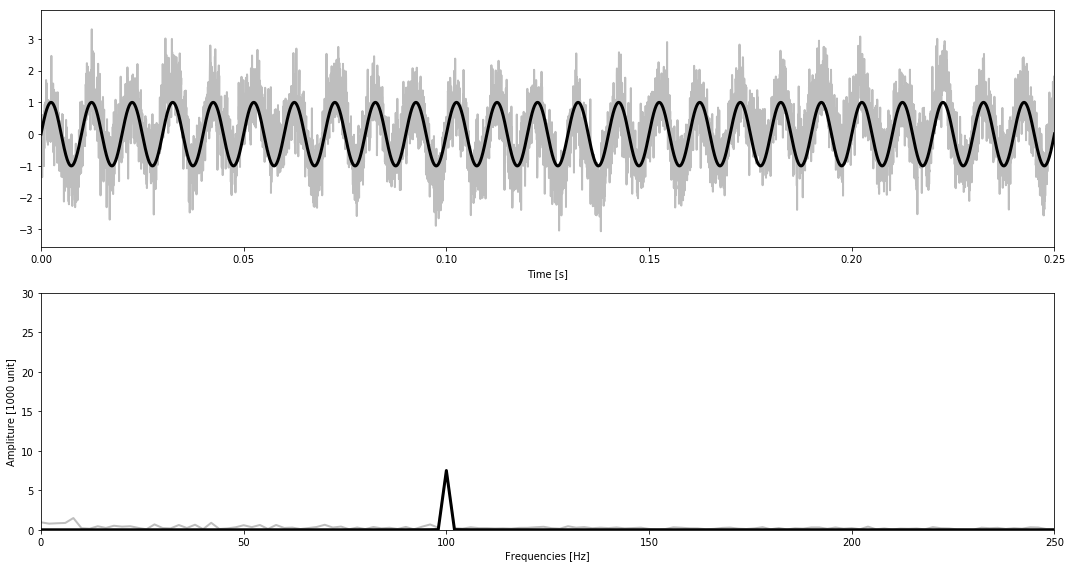

In [3]:
figs, axs = plt.subplots(2, 1, figsize=(15, 8))

axs[0].plot(t, xn, c='C7', lw=2, alpha=.5)
axs[0].plot(t, x, c='k', lw=3)
axs[0].set_xlim([0, 0.25])
axs[0].set_xlabel('Time [s]')

scale = 1E-3
axs[1].plot(w, np.abs(Xn) * scale, c='C7', lw=2, alpha=.5)
axs[1].plot(w, np.abs(X) * scale, c='k', lw=3)
axs[1].set_xlim([0, 250])
axs[1].set_ylim([0, 30])
axs[1].set_xlabel('Frequencies [Hz]')
axs[1].set_ylabel('Ampliture [{} unit]'.format(int(1/scale)))
plt.tight_layout()

In [4]:
mode = None
from mu import time_frequency as tf
binsize = 2**12
hopsize = binsize // 2

if mode is 'full':
    fftfreq_ = np.fft.fftfreq
else:
    fftfreq_ = np.fft.rfftfreq
    
Xn_ = tf.stft.stft(xn, binsize=binsize, hopsize=hopsize, window='hanning', mode=mode)
wn_ = fftfreq_(binsize) * fs

Text(0, 0.5, 'Frequencies [Hz]')

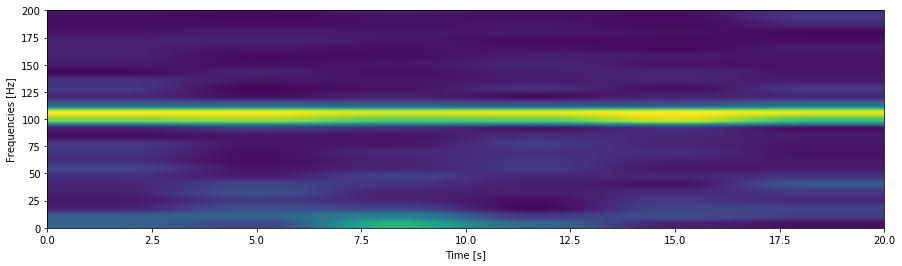

In [5]:
plt.figure(figsize=(15, 4))
plt.imshow(np.abs(Xn_)[0,:,:binsize//2].T,
           aspect='auto',
           origin='lower',
           interpolation='hanning',
           extent=[0, 20, 0, fs//2])

# plt.xlim([0, 5])
plt.ylim([0, 200])
plt.xlabel('Time [s]')
plt.ylabel('Frequencies [Hz]')

# FilterBank Example

In [6]:
# Initialize the filter bank class
dec = 16
center_freqs = np.array([100, 300, 600])
# center_freqs = np.array([100])
bandwidth = 50
freq_bands = None

fb = FilterBank(nch=1, nsamp=nsamp, binsize=binsize, decimate_by=dec, \
                bandwidth=bandwidth, center_freqs=center_freqs, freq_bands=freq_bands, order=binsize, sample_rate=fs, \
                hilbert=False, domain='time', nprocs=1, mprocs=False, zero_phase=True,
                logger=None)

In [7]:
xf = fb.analysis(np.atleast_2d(xn), window='hanning')
%timeit fb.analysis(np.atleast_2d(xn), window='hanning')
fb.kill()

1.03 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
Xf = np.fft.rfft(xf, axis=-1)
wf = np.fft.rfftfreq(xf.shape[-1]) * (fs/dec)

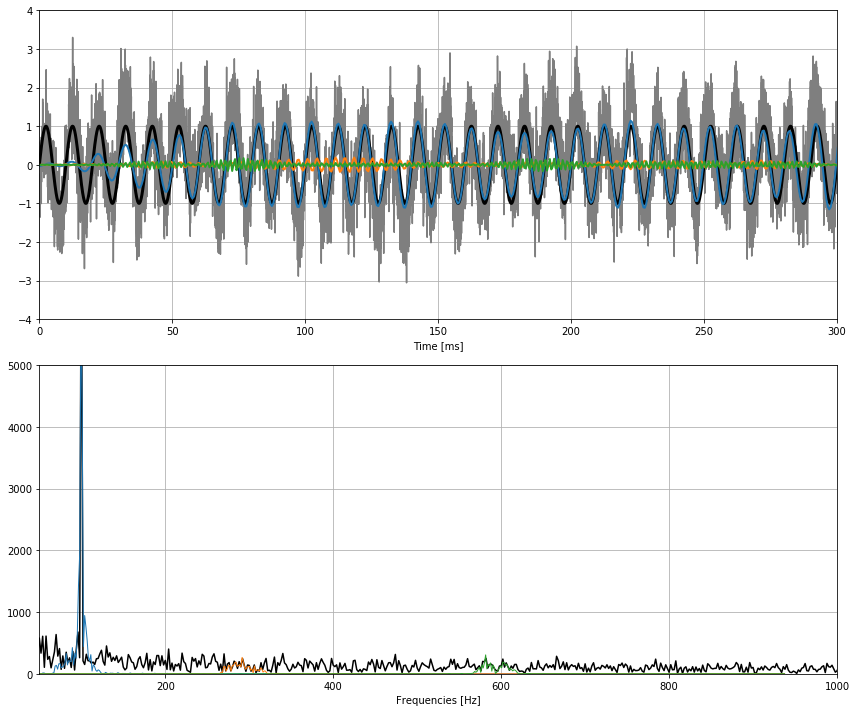

In [12]:
plt.figure(figsize=(12, 10))
plt.subplot(211)
plt.plot(t*1000, xn, c='C7')
plt.plot(t*1000, x, c='k', lw=3)
plt.plot((np.arange(xf.shape[-1])/(fs/dec))*1000, xf.T, '-', lw=2)

plt.xlim([0, 300])
plt.ylim([-4, 4])
plt.xlabel('Time [ms]')
plt.grid(True)

plt.subplot(212)
plt.plot(w[1:], np.abs(Xn)[1:], c='k')
plt.plot(wf, np.abs(Xf).T * dec, alpha=1, lw=1)

plt.xlim([50, 2000/2])
plt.ylim([0, 5000])
plt.xlabel('Frequencies [Hz]')
plt.grid(True)
plt.tight_layout()

## Notes:
Notice the slight scaling issue in the low frequencies. This is because that filter bank (at the moment) filters all signals using only one bandpass filter. A typical application of filtering from 0-100 Hz should be done in lowpass filter, but that would introduce additional complexity in the implementation and will be overlooked for now.

# Spectrogram Example

In [10]:
# spec = Spectrogram(nch=1, nsamp=nsamp, sample_rate=fs, binsize=2**9, hopsize=None, overlap_factor=.5)
# X_ = spec.analysis(sig)

In [11]:
# spec.plot_spectra(ch=None, axs=None, tlim=None, flim=(0, 5000), figsize=(8, 6), norm='db',
#                   title=None, label=False, xlabel=True, ylabel=True,
#                   fontsize={'ticks': 15, 'axis': 15, 'title': 20})